# Walmart Recruiting - Store Sales Forecasting

# Overview:

Walmart is one of the leading stores in the US. Walmart would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 Walmart stores located in different region. The business is facing a challenge due to unforeseen demands and runs out of stock sometimes, due to the inappropriate machine learning algorithm. 

# Business Case:

we are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments and we must predict the sales for each department in each store. Also modelling the effects of markdowns on holiday weeks and to predict which departments are affected and the extent of the impact. The data has Store as the primary key over which we have joined these tables. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

# Objective:

To predict weekly sales for each department of all the stores.

# Data Field Information 

<h3>stores.csv</h3>This file contains anonymized information about the 45 stores, indicating the type and size of store.

<h3>train.csv</h3> This is the historical training data, which covers to 2010–02–05 to 2012–11–01. Within this file you will find the following fields: 

- Store — the store number(45 stores)
- Dept — the department number(99 departments)
- Date — the week
- Weekly Sales — sales for the given department in the given store
- IsHoliday — Whether the week is a special holiday week
- test.csv This fie is identical to train.csv, except we have withheld

<h3>test.csv</h3> This fie is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

<h3>features.csv</h3> This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store — the store number
- Date — the week
- Temperature — average temperature in the region
- Fuel_Price — cost of fuel in the region
- MarkDown1–5 — anonymized data related to promotional markdowns that Walmart is running. Markdown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI — the consumer price index
- Unemployment — the unemployment rate
- IsHoliday — whether the week is a special holiday week


# Evaluation Metric:

Walmart has provided Weighted Mean Absolute Error (WMAE) metric, the mathematical function for which is shown below.

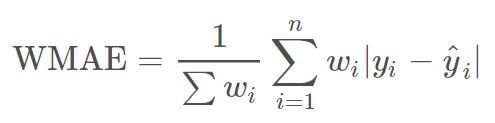

- I am using wmae as metric instead of MAE.The MAE is a linear score which means that all the individual differences are weighted equally in the average. 
- In case of sales forecasing if there is a holiday so there is more chance of sales so here I am giving more weight to holiday variable.
- here we can also use rmse.Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 
- rmse gives high weight to large errors. This means rmse is useful when large error is undesirable.rmse gives the idea of on an average how much value away from actual value.

# 1. Library and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams
import seaborn as sns
from tqdm import tqdm
from datetime import date
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from tensorflow.keras.models import load_model
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

In [97]:
df_stores = pd.read_csv('stores.csv')
df_features = pd.read_csv('features.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 2. Data Observation

### stores

In [98]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [99]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [100]:
#how many data point for each store type present
df_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

Text(0, 0.5, 'Number of Stores ')

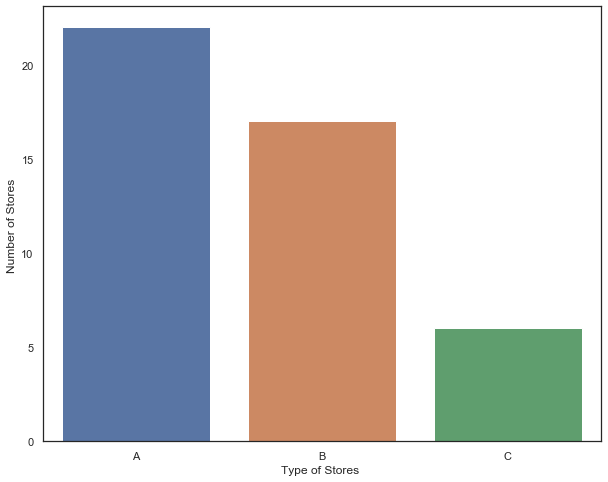

In [101]:
x = np.array(df_stores['Type'].value_counts().index)
y = np.array(df_stores['Type'].value_counts().values)
sns.barplot(x,y)
plt.xlabel('Type of Stores ')
plt.ylabel('Number of Stores ')

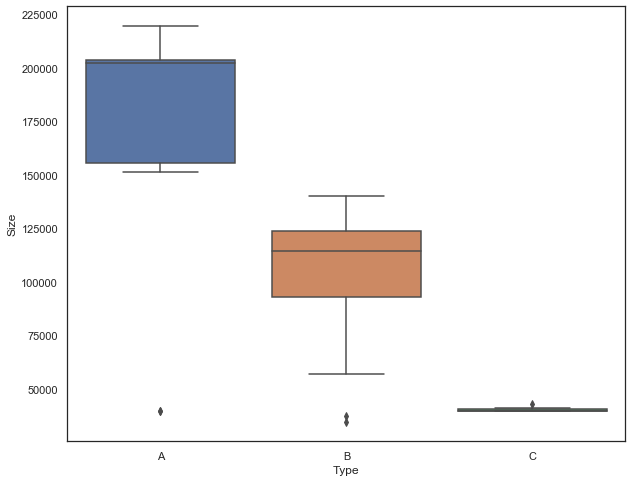

In [102]:
sns.boxplot(x='Type', y='Size', data=df_stores)

### Observations:

there are less number of type c stores.

### features 

In [103]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [104]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


### train

In [105]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [106]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [107]:
df_train['IsHoliday'].value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

### test

In [108]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


# 3. Data Manipulation

In [110]:
#merge all features
df_features_stores = pd.merge(df_features,df_stores)
train = pd.merge(df_features_stores, df_train)
train.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38


In [111]:
train.shape

(421570, 16)

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     150681 non-null  float64
 5   MarkDown2     111248 non-null  float64
 6   MarkDown3     137091 non-null  float64
 7   MarkDown4     134967 non-null  float64
 8   MarkDown5     151432 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          421570 non-null  object 
 13  Size          421570 non-null  int64  
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [17]:
test = pd.merge(df_features_stores, df_test)
test.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept
0,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,1
1,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,2
2,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,3
3,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,4
4,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,5


In [18]:
test.shape

(115064, 15)

In [19]:
train.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
Dept              int64
Weekly_Sales    float64
dtype: object

In [20]:
#Since the records are weekly, the "date" variable was converted to week of the year and year, as two new variables.
#https://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month

train['Week'] = train['Date'].dt.week
test['Week'] = test['Date'].dt.week

train['Year'] = train['Date'].dt.year
test['Year'] = test['Date'].dt.year

train['day'] = train['Date'].dt.day
test['day'] = test['Date'].dt.day

# train = train.drop(['Date'], axis=1)
# test = test.drop(['Date'], axis=1)

In [21]:
#REf:https://www.geeksforgeeks.org/how-to-check-whether-the-day-is-a-weekday-or-not-using-pandas-in-python/
# Creating a Function
def check_weekday(date):
      
    # computing the parameter date
    # with len function
    res=len(pd.bdate_range(date,date))
      
    if res == 0 :
        return 1
    else:
        return 0

In [22]:
check_weekday('2010-05-07')

0

# 4. Feature Transformation

### Holidays

According to the challenge instructions, the holiday dates are expected to have a greater weight in the model training, since in general they represent a greater volume of sales.

The code below shows all dates that represent holidays, both in the train and test dataset. It is observed that the holidays are in the same weeks (6, 36, 47 and 52) for the years 2010, 2011, 2012 and 2013. From the data provided by the challenge, it is possible to identify what these holidays are.

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 --> WEEK 6
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 --> WEEK 36
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 --> WEEK 47
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 --> WEEK 52

It is noticed that there are no sales records on the laborday holiday at the test dataset, since the holiday is in September and the test runs until July.

In [23]:
#https://www.geeksforgeeks.org/python-holidays-library/#:~:text=Python%20Holidays%20library%20is%20an,Christmas%2C%20New%20Year%2C%20etc.
# # Print all the holidays in US in year 2018
year = [2010, 2011, 2012]
for i in year:
    for ptr in holidays.US(years = i).items():
        print(ptr)
    print("##################################################################")

(datetime.date(2010, 1, 1), "New Year's Day")
(datetime.date(2010, 12, 31), "New Year's Day (Observed)")
(datetime.date(2010, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2010, 2, 15), "Washington's Birthday")
(datetime.date(2010, 5, 31), 'Memorial Day')
(datetime.date(2010, 7, 4), 'Independence Day')
(datetime.date(2010, 7, 5), 'Independence Day (Observed)')
(datetime.date(2010, 9, 6), 'Labor Day')
(datetime.date(2010, 10, 11), 'Columbus Day')
(datetime.date(2010, 11, 11), 'Veterans Day')
(datetime.date(2010, 11, 25), 'Thanksgiving')
(datetime.date(2010, 12, 25), 'Christmas Day')
(datetime.date(2010, 12, 24), 'Christmas Day (Observed)')
##################################################################
(datetime.date(2011, 1, 1), "New Year's Day")
(datetime.date(2010, 12, 31), "New Year's Day (Observed)")
(datetime.date(2011, 1, 17), 'Martin Luther King Jr. Day')
(datetime.date(2011, 2, 21), "Washington's Birthday")
(datetime.date(2011, 5, 30), 'Memorial Day')
(datetime.date(2

In [24]:
holiday_train = train[['Date','Week','Year','IsHoliday']]
holiday_train = holiday_train.loc[holiday_train['IsHoliday']==True].drop_duplicates()

holiday_test = test[['Date','Week','Year','IsHoliday']]
holiday_test = holiday_test.loc[holiday_test['IsHoliday']==True].drop_duplicates()

holidays = pd.concat([holiday_train, holiday_test])
holidays

,Date,Week,Year,IsHoliday
73,2010-02-12,6,2010,True
2218,2010-09-10,36,2010,True
3014,2010-11-26,47,2010,True
3372,2010-12-31,52,2010,True
3800,2011-02-11,6,2011,True
5940,2011-09-09,36,2011,True
6731,2011-11-25,47,2011,True
7096,2011-12-30,52,2011,True
7527,2012-02-10,6,2012,True
9667,2012-09-07,36,2012,True


In [25]:
def holiday_type(x):
    if   (x['IsHoliday']== 1) & (x['Week']==6):
        return 1 #SuperBowl
    elif (x['IsHoliday']== 1) & (x['Week']==36):
        return 2 #LaborDay
    elif (x['IsHoliday']== 1) & (x['Week']==47):
        return 3 #Thanksgiving
    elif (x['IsHoliday']== 1) & (x['Week']==52):
        return 4 #Christmas
    else:
        return 0

In [26]:
#converting IsHoliday into 0 and 1
train['IsHoliday'] = train.apply(holiday_type, axis=1)
test['IsHoliday'] = test.apply(holiday_type, axis=1)

### Type

In [27]:
train['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [28]:
#converting store type A,B,C into 3,2,1
train['Type'] = train['Type'] .apply(lambda x: 3 if x == 'A' else 2 if x == 'B' else 1)
test['Type'] = test['Type'] .apply(lambda x: 3 if x == 'A' else 2 if x == 'B' else 1)

In [29]:
train.isnull().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales         0
Month                0
Week                 0
Year                 0
day                  0
dtype: int64

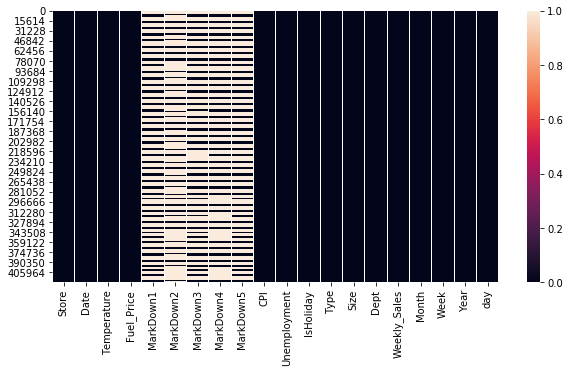

In [30]:
plt.figure(figsize = (10,5))
sns.heatmap(train.isnull());

In [31]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
MarkDown2,310322,0.736110
MarkDown4,286603,0.679847
MarkDown3,284479,0.674808
MarkDown1,270889,0.642572
MarkDown5,270138,0.640790
day,0,0.000000
Year,0,0.000000
Date,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000


- since markdown 1 to 5 have more than 60 % missing values, are not strongly correlated to 'Weekly_sales' ie. it's diifficult to understand what they mean, so we can drop them.

In [32]:
train = train.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1)
test = test.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1)

In [33]:
train.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month,Week,Year,day
0,1,2010-02-05,42.31,2.572,211.096358,8.106,0,3,151315,1,24924.50,2,5,2010,5
1,1,2010-02-05,42.31,2.572,211.096358,8.106,0,3,151315,2,50605.27,2,5,2010,5
2,1,2010-02-05,42.31,2.572,211.096358,8.106,0,3,151315,3,13740.12,2,5,2010,5
3,1,2010-02-05,42.31,2.572,211.096358,8.106,0,3,151315,4,39954.04,2,5,2010,5
4,1,2010-02-05,42.31,2.572,211.096358,8.106,0,3,151315,5,32229.38,2,5,2010,5


In [34]:
train.to_csv('train1.csv')

# 5. Data Visualization

#### Histogram 

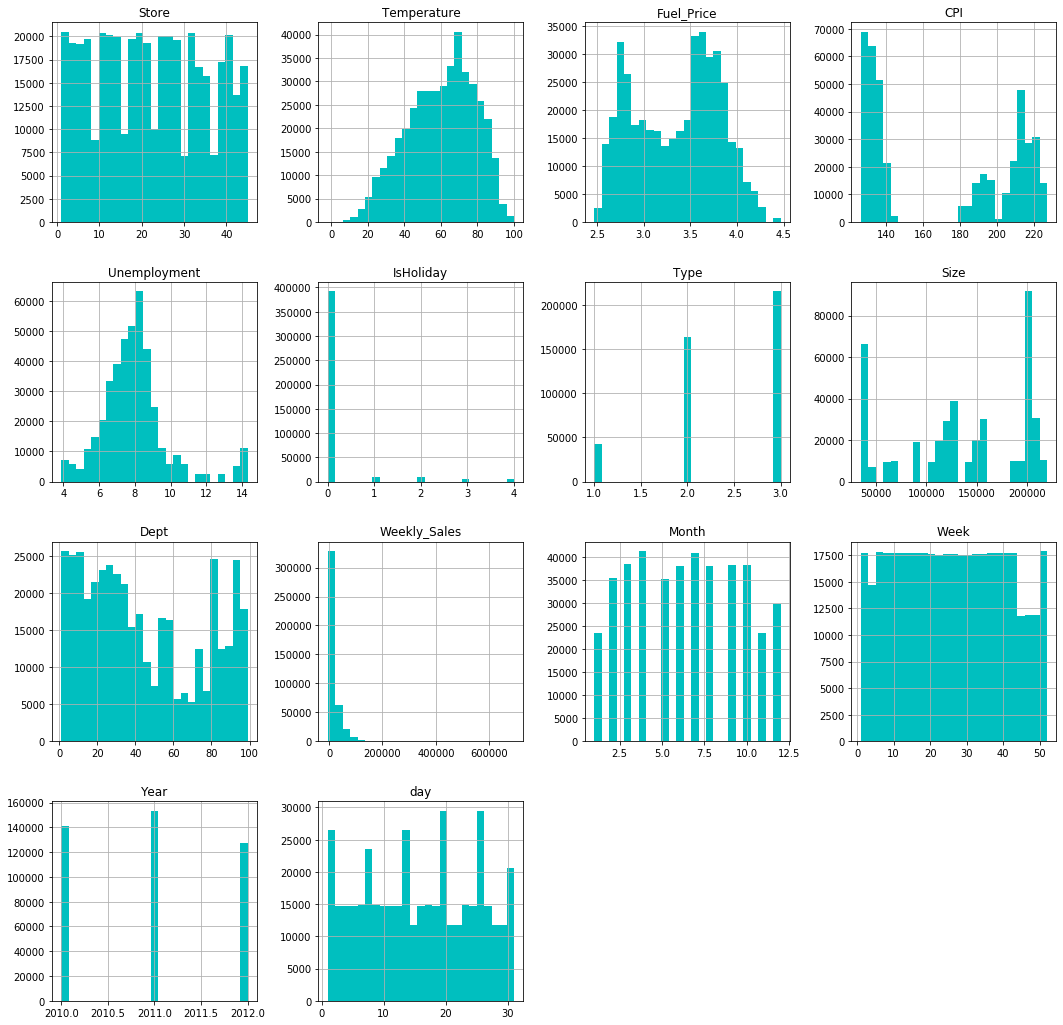

In [35]:
train.hist(bins = 25, figsize=(18, 18), color = 'c')
plt.show()

### Sales per IsHoliday

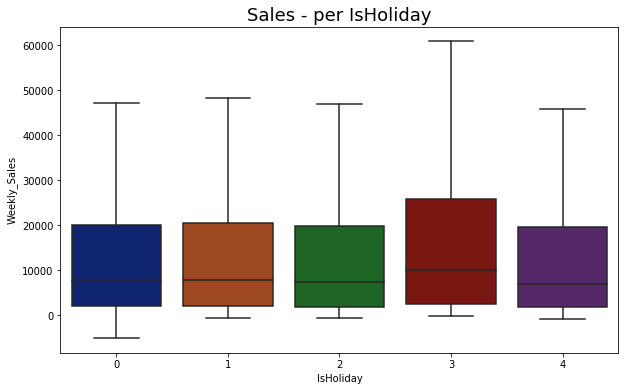

In [36]:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.figure(figsize=(10,6))
sns.boxplot(x='IsHoliday',y='Weekly_Sales', data=train,palette='dark', showfliers=False)
plt.title('Sales - per IsHoliday', fontsize=18)
plt.show()
plt.show()

- Sales in holiday(Thanksgiving) is more as compare to other days.

### Sales per Year

In [37]:
train.groupby('Year')['Weekly_Sales'].mean()

Year
2010    16270.275737
2011    15954.070675
2012    15694.948597
Name: Weekly_Sales, dtype: float64

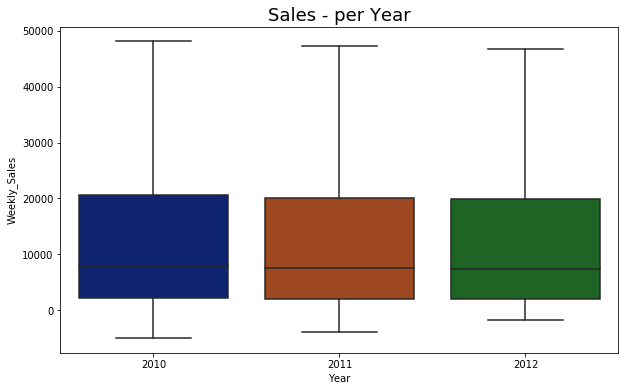

In [38]:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.figure(figsize=(10,6))
sns.boxplot(x='Year',y='Weekly_Sales', data=train,palette='dark', showfliers=False)
plt.title('Sales - per Year', fontsize=18)
plt.show()
plt.show()

- sales obtain in year 2010 is slightly more as compared to other year.

### Sales per Month 

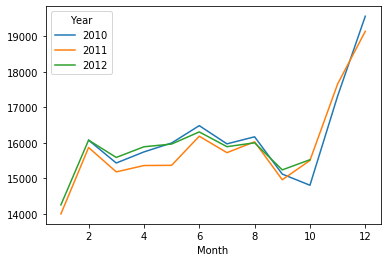

In [39]:
monthly_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales.plot()

- From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

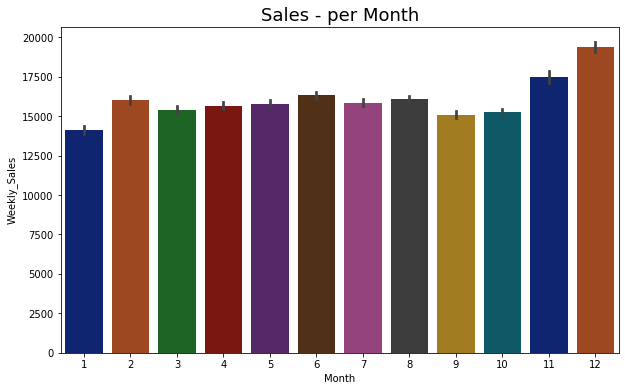

In [40]:

plt.figure(figsize=(10,6))
sns.barplot(x='Month',y='Weekly_Sales', data=train,palette='dark')
plt.title('Sales - per Month', fontsize=18)
plt.show()
plt.show()

- When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

### Sales per Week

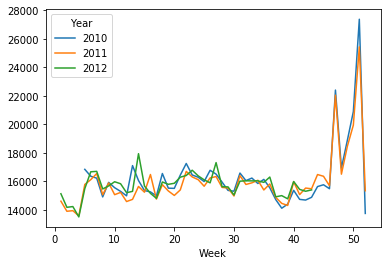

In [41]:
weekly_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Week")
weekly_sales.plot()

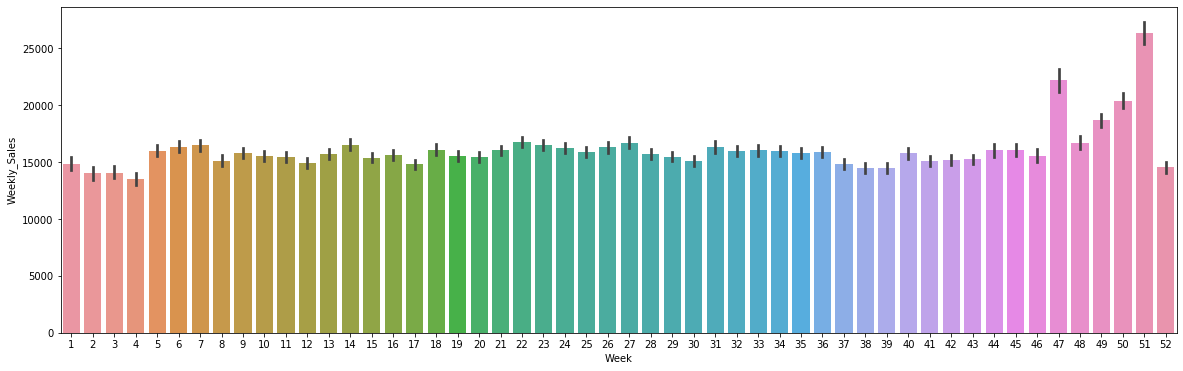

In [42]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Week', y='Weekly_Sales', data=train)

- From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

### Weekly sales per Store

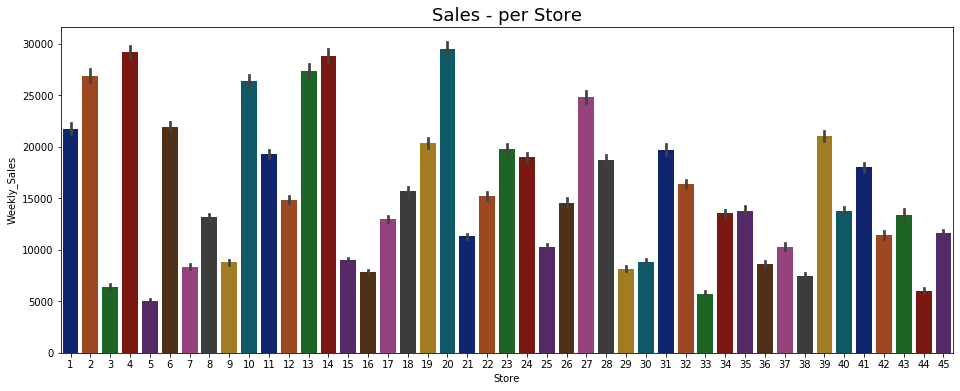

In [43]:
#https://seaborn.pydata.org/generated/seaborn.barplot.html
rcParams['figure.figsize'] = 16.0,6.0
sns.barplot(x = "Store", y = "Weekly_Sales", data = train, palette='dark')
plt.title('Sales - per Store', fontsize=18)
plt.show()

Analyzing the average weekly sales per store, there is a strong variation in sales volume between stores, ranging from 5000 up to 30000

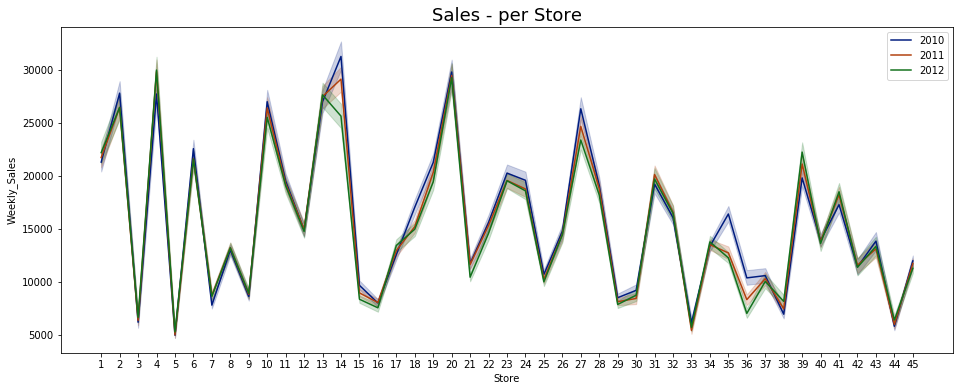

In [44]:
#https://seaborn.pydata.org/generated/seaborn.lineplot.html
rcParams['figure.figsize'] = 16.0,6.0
sns.lineplot(x = "Store", y = "Weekly_Sales",hue='Year', data = train, palette='dark')
plt.title('Sales - per Store', fontsize=18)
plt.xticks(np.arange(1, 46, step=1))
plt.legend()
plt.show()

The behaviour of stores remain stable over the year. Some stores showed decrese in sales over the years such as stores 14,24,35.

### Weekly sales per Department

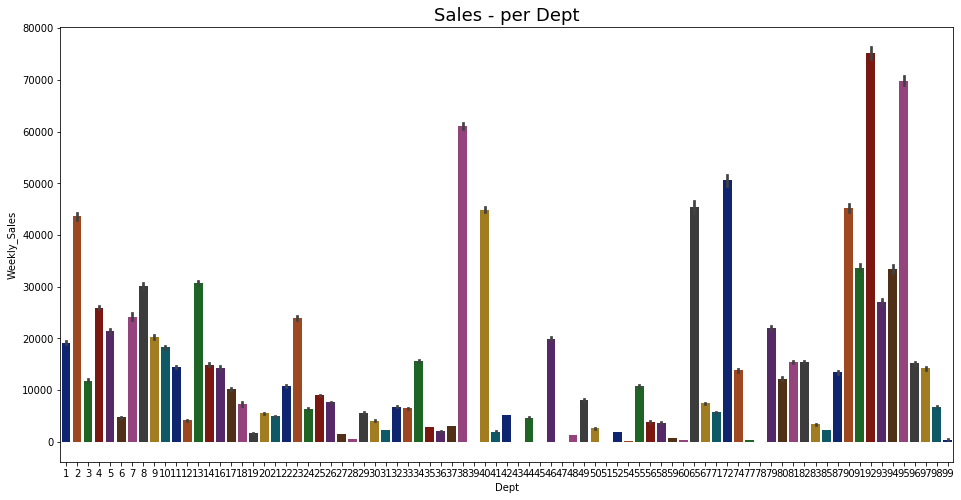

In [45]:
rcParams['figure.figsize'] = 16.0,8.0
sns.barplot(x = "Dept", y = "Weekly_Sales", data = train, palette='dark')
plt.title('Sales - per Dept', fontsize=18)
plt.show()

There are so much irregularities on weekly sales by department with average sales start from 0 to more than 70000.

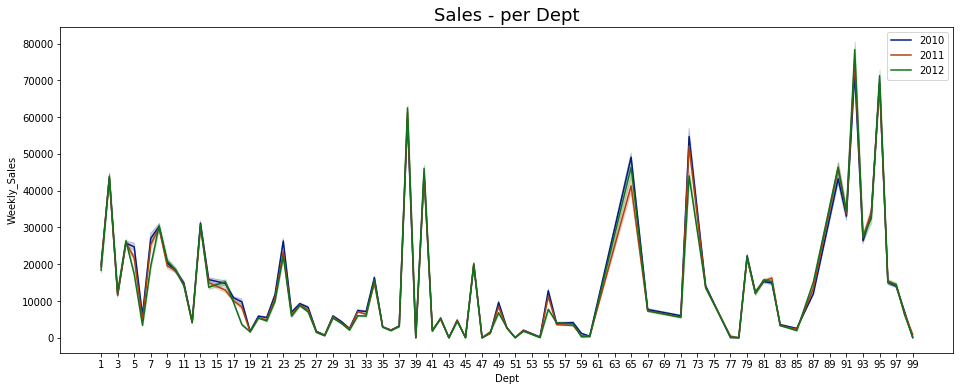

In [46]:
rcParams['figure.figsize'] = 16.0,6.0
sns.lineplot(x = "Dept", y = "Weekly_Sales",hue='Year', data = train, palette='dark')
plt.title('Sales - per Dept', fontsize=18)
plt.xticks(np.arange(1, 100, step=2))
plt.legend()
plt.show()

The behaviour of department remain stable over the year. Some department showed decrese in sales over the years such as department 65, 73.

### sales per Size

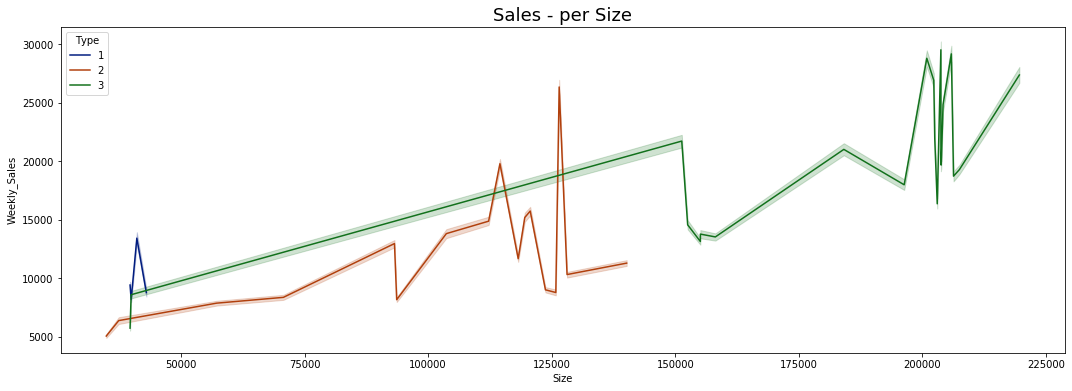

In [47]:
rcParams['figure.figsize'] = 18,6
sns.lineplot(x = "Size", y = "Weekly_Sales",hue='Type', data = train, palette='dark')
plt.title('Sales - per Size', fontsize=18)
plt.show()

 - The chart indicate there is trend towards higher sales for large stores.




#### Sales per Type

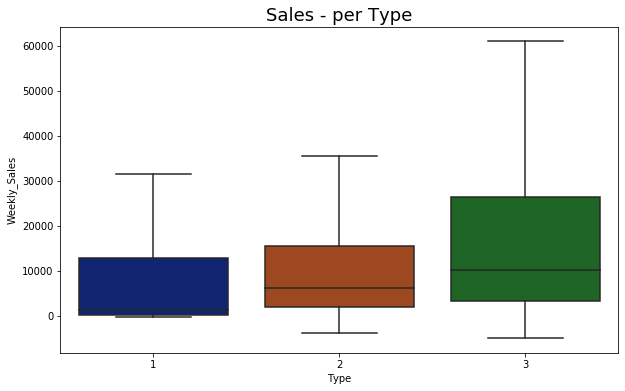

In [48]:
rcParams['figure.figsize'] = 10,6
sns.boxplot(x = "Type", y = "Weekly_Sales", data = train, palette='dark',showfliers = False)
plt.title('Sales - per Type', fontsize=18)
plt.show()

- Type 3 has higher sales median than type 1 and type 2. Type 1 tends to have lower weekly sales.

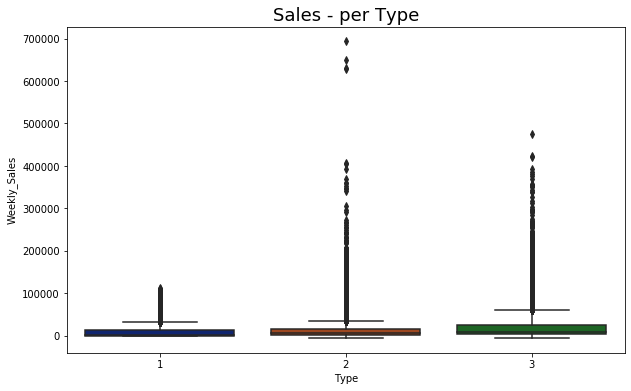

In [49]:
rcParams['figure.figsize'] = 10,6
sns.boxplot(x = "Type", y = "Weekly_Sales", data = train, palette='dark')
plt.title('Sales - per Type', fontsize=18)
plt.show()

- Despite despersion around median Type 2 has many outlier records.

### Sales per Fuel Price

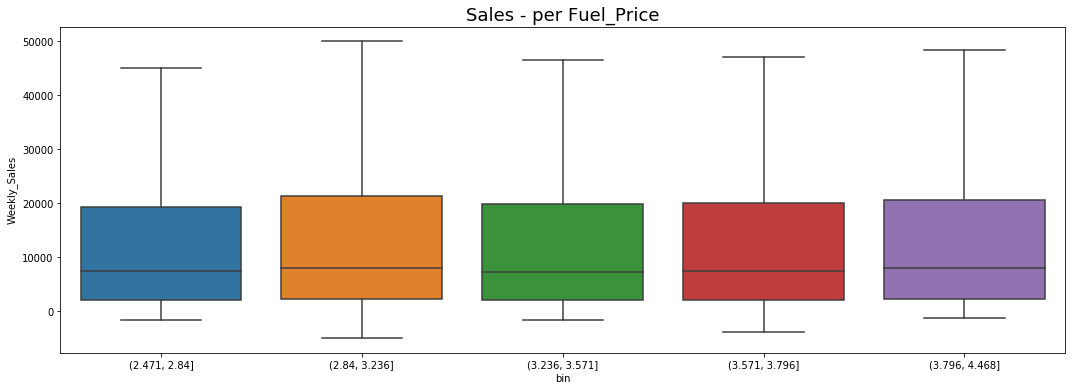

In [50]:
#https://hippocampus-garden.com/pandas_boxplot/
rcParams['figure.figsize'] = 18,6
df = train[['Fuel_Price', 'Weekly_Sales']]
df["bin"] = pd.qcut(df["Fuel_Price"], 5)
sns.boxplot(x="bin", y="Weekly_Sales", data=df, showfliers = False);
plt.title('Sales - per Fuel_Price', fontsize=18)
plt.show()

- There is no such strong correlation between sales and fuel price but we can observe that sales is when fuel price is between 2.84 and 3.236.

### Sales per Temprature

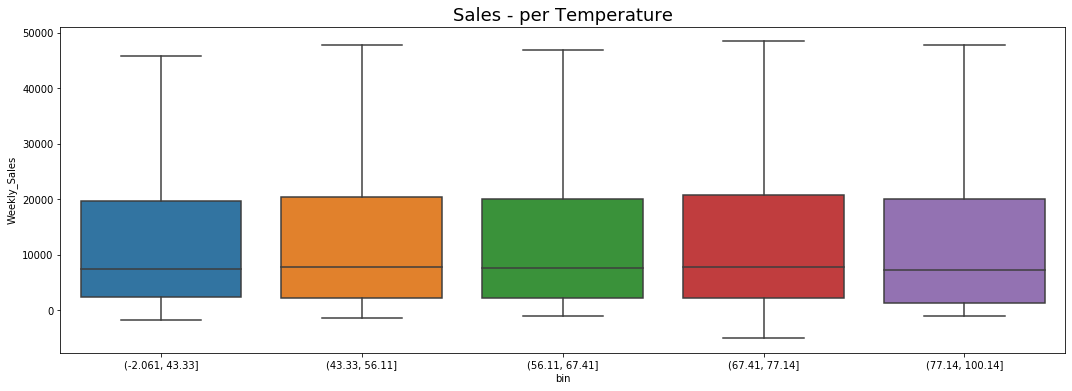

In [51]:
#https://hippocampus-garden.com/pandas_boxplot/
rcParams['figure.figsize'] = 18,6
df = train[['Temperature', 'Weekly_Sales']]
df["bin"] = pd.qcut(df["Temperature"], 5)
sns.boxplot(x="bin", y="Weekly_Sales", data=df, showfliers = False);
plt.title('Sales - per Temperature', fontsize=18)
plt.show()

- Sales is high when temperature range is between 43.33 and 56.11.

### Scatter plot

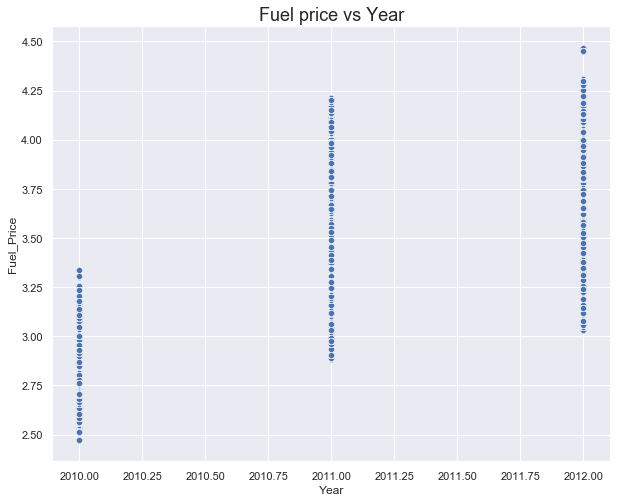

In [52]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(train['Year'],train['Fuel_Price'], palette="dark");
plt.title("Fuel price vs Year", fontsize=18)
plt.show()

- As year increasing fuel price is also increasing.

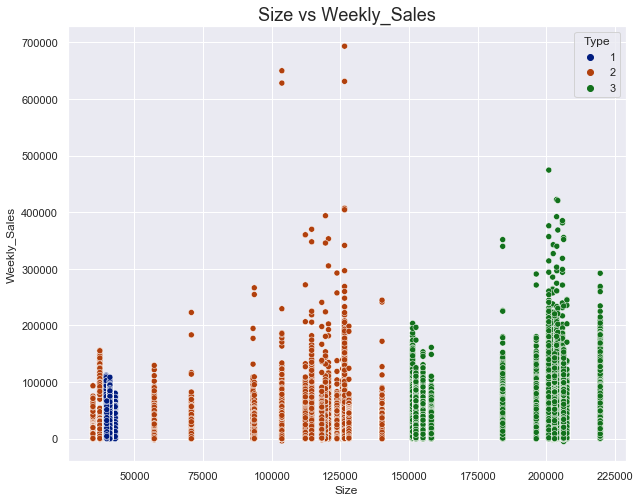

In [53]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(train['Size'],train['Weekly_Sales'], hue=train['Type'], palette="dark");
plt.title("Size vs Weekly_Sales", fontsize=18)
plt.show()

- As size is increasing, sales is also increasing. Type 3 tends to have larger size which have more weekly sales apart from that there is some outliers are availabe in type 2.

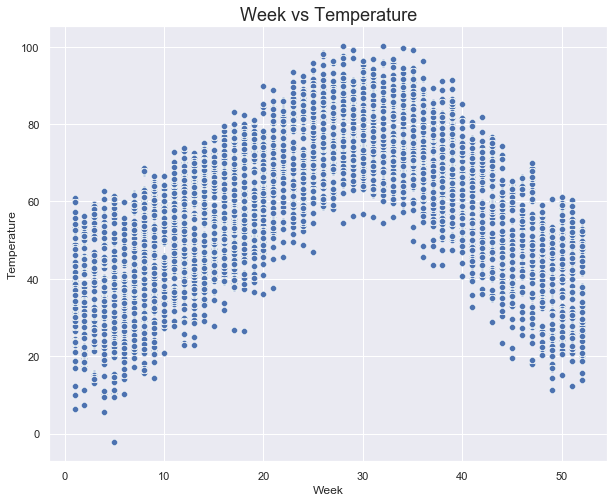

In [54]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(train['Week'],train['Temperature'], palette="dark");
plt.title("Week vs Temperature", fontsize=18)
plt.show()

- There no such certain relationship between week and temperature but we can observe from the plot that temperature is high between week 20 and 40.

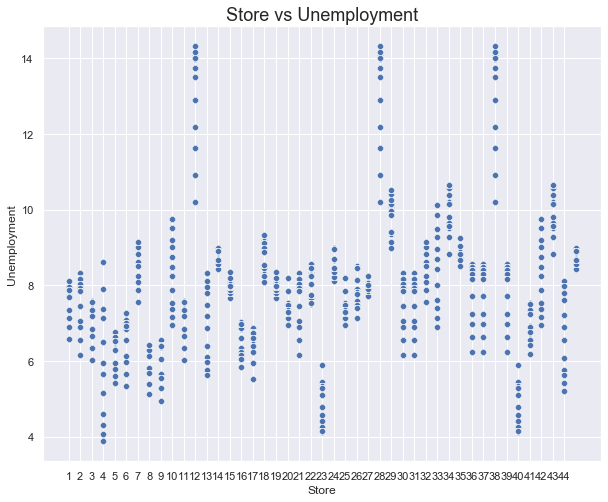

In [55]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(train['Store'],train['Unemployment'], palette="dark");
plt.xticks(np.arange(1, 45, step=1))
plt.title("Store vs Unemployment", fontsize=18)
plt.show()

- From the above plot its difficult to conclude but we can observe that store 12,29, 38 have high unemployment.

### Correlation

In [56]:
# correlation between categorical variable
#Refer:https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/
CrosstabResult=pd.crosstab(index=train['Type'],columns=train['Weekly_Sales'])
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value>0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.9999939893812583


- Since P-value came higher than 0.05. Hence H0 will be accepted. Which means the variables are not correlated with each other.

- This means, if two variables are correlated, then the P-value will come very close to zero.

In [57]:
#correlation between categorical and numerical variable
c1 = ['IsHoliday','Type']
c2 = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Size', 'Dept', 'Weekly_Sales', 'Month', 'Week',
       'Year', 'day']

for i in c1:
    for j in c2:
        CategoryGroupLists=train.groupby(i)[j].apply(list)
        # Performing the ANOVA test
        # We accept the Assumption(H0) only when P-Value > 0.05
        AnovaResults = f_oneway(*CategoryGroupLists)
        print('P-Value for Anova between {} and {} is:'.format(i,j), AnovaResults[1])
        if AnovaResults[1] < 0.05:
            print('{} and {} are correalted'.format(i,j))
        else:
            print('{} and {} are not correalted'.format(i,j))
        print(' ')
    print("###############################################################################################")
        

P-Value for Anova between IsHoliday and Store is: 0.9838567743096112
IsHoliday and Store are not correalted
 
P-Value for Anova between IsHoliday and Temperature is: 0.0
IsHoliday and Temperature are correalted
 
P-Value for Anova between IsHoliday and Fuel_Price is: 0.0
IsHoliday and Fuel_Price are correalted
 
P-Value for Anova between IsHoliday and CPI is: 0.08832768036473782
IsHoliday and CPI are not correalted
 
P-Value for Anova between IsHoliday and Unemployment is: 6.949396645131818e-26
IsHoliday and Unemployment are correalted
 
P-Value for Anova between IsHoliday and Size is: 0.9868138650722665
IsHoliday and Size are not correalted
 
P-Value for Anova between IsHoliday and Dept is: 0.961388206659232
IsHoliday and Dept are not correalted
 
P-Value for Anova between IsHoliday and Weekly_Sales is: 6.294017252104449e-103
IsHoliday and Weekly_Sales are correalted
 
P-Value for Anova between IsHoliday and Month is: 0.0
IsHoliday and Month are correalted
 
P-Value for Anova between 

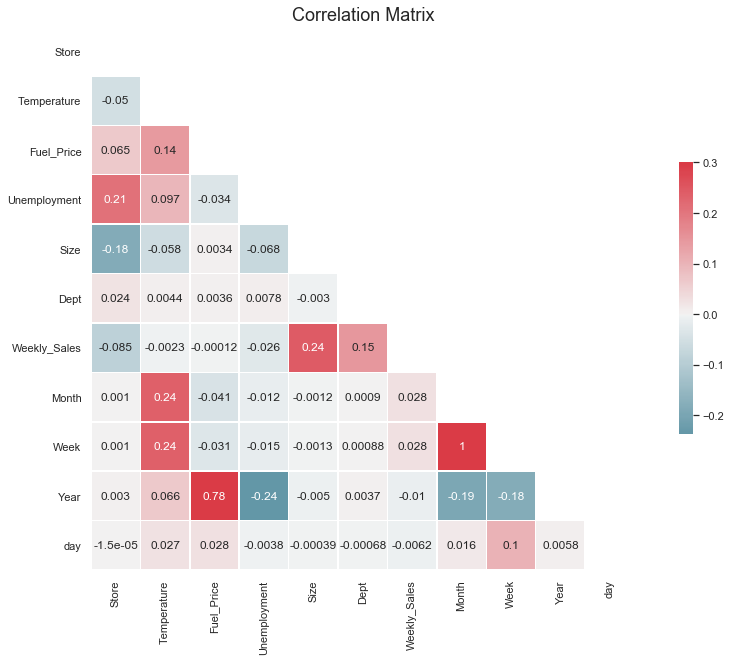

In [58]:
#http://seaborn.pydata.org/examples/many_pairwise_correlations.html
num_corr = train[['Store', 'Date','Temperature','Fuel_Price','Unemployment','Size','Dept','Weekly_Sales','Month','Week','Year','day']]
sns.set(style="white")
corr_num = num_corr.corr()
mask = np.triu(np.ones_like(corr_num, dtype=np.bool))
f, ax = plt.subplots(figsize=(16, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr_num, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [59]:
corr_num['Weekly_Sales'].sort_values()

Store          -0.085195
Unemployment   -0.025864
Year           -0.010111
day            -0.006187
Temperature    -0.002312
Fuel_Price     -0.000120
Week            0.027673
Month           0.028409
Dept            0.148032
Size            0.243828
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

 - 'Fuel_Price', 'Temperature', 'Date', 'CPI', 'Unemployment' have week negative correlation with 'Weekly_sales', so they will be dropped.

In [60]:
df_train_feats = train.drop(columns=['Fuel_Price', 'Temperature','Date', 'CPI', 'Unemployment'])
df_test_feats = test.drop(columns=['Fuel_Price', 'Temperature','Date', 'CPI', 'Unemployment'])

# Explorations & Findings

### EDA 

- There are 45 stores and 81 department in data. Departments are not same in all stores.
- Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time.
- Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales.
- Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
- As expected, holiday average sales are higher than normal dates.
- Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
- Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
- It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May.
- January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
- CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales.

### Feature Engineering

- Data needs more feature engineering but as a first insight, week, year and month columns were created to see and analyze results in detail. Week column is an important feature because our data is weekly and we can see which week of the year sales have significant changes.
- Also, holidays were divided columns as Thankgiving, Christmas, Labor day and Super Bowl to see the effects on different holidays.













# Arima Model

In [122]:
df = pd.read_csv('train1.csv')

In [123]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [124]:
df.set_index('Date', inplace=True) #seting date as index

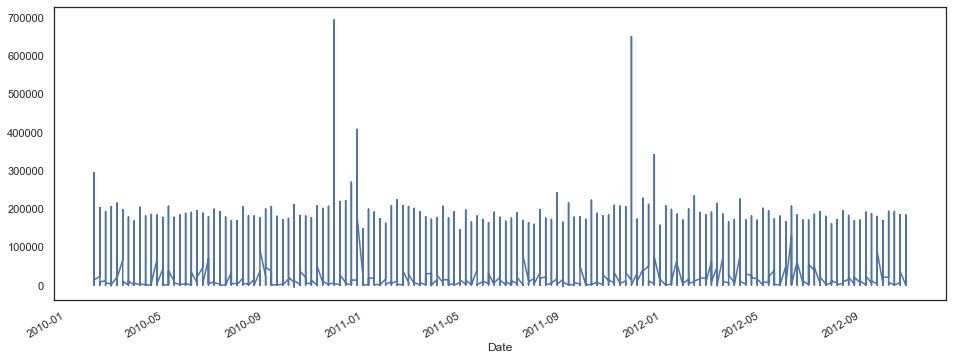

In [125]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In [126]:
df_week = df.resample('W').mean() #resample data as weekly
print(df_week.shape)

(143, 15)


In [127]:
df_week.head()

,Unnamed: 0,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,Month,Week,Year,day
Date,,,,,,,,,,,,,,,
2010-02-07,204507.393232,22.038579,33.277942,2.717869,167.398405,8.576731,0.0,2.412183,137430.535364,44.181726,16836.121997,2.0,5.0,2010.0,5.0
2010-02-14,204359.014547,22.016915,33.361810,2.696102,167.384138,8.567309,1.0,2.414073,137622.780785,44.377199,16352.056032,2.0,6.0,2010.0,12.0
2010-02-21,204641.447430,22.038965,37.038310,2.673666,167.338966,8.576351,0.0,2.412160,137278.637219,44.305341,16216.658979,2.0,7.0,2010.0,19.0
2010-02-28,204720.032870,22.041681,38.629563,2.685642,167.691019,8.561375,0.0,2.412064,137346.344629,44.107421,14899.549688,2.0,8.0,2010.0,26.0
2010-03-07,204805.752038,22.043818,42.373998,2.731816,167.727351,8.572689,0.0,2.414062,137576.841033,44.045516,15921.015727,3.0,9.0,2010.0,5.0


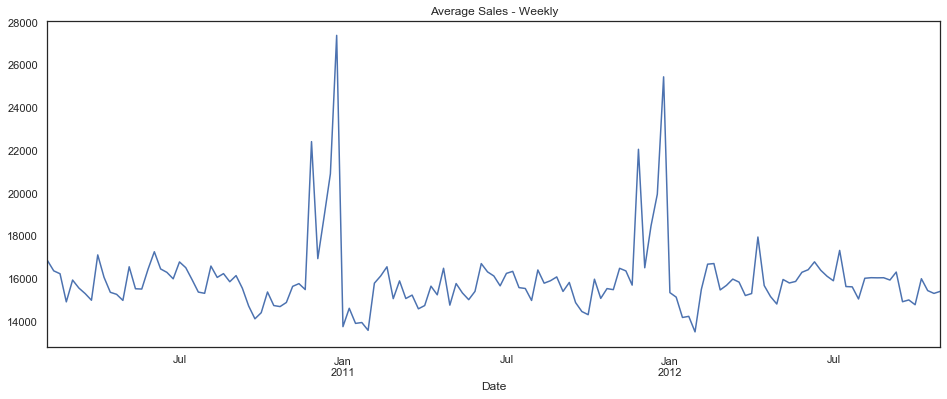

In [128]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [129]:
df_month = df.resample('MS').mean() # resampling as monthly
df_month.shape

(33, 15)

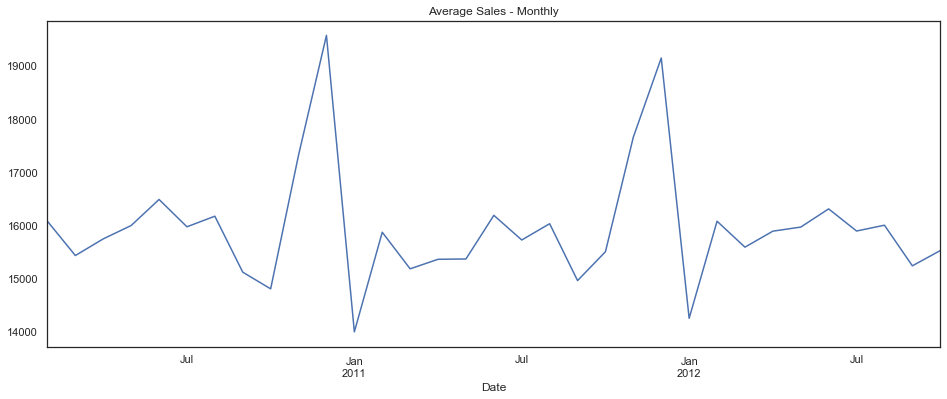

In [130]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [131]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_week['Weekly_Sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.93080274474869
p-value: 2.383227270610516e-07
Critical Values:
	1%: -3.47864788917503
	5%: -2.882721765644168
	10%: -2.578065326612056


- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
- here p value is less than 0.05 ie data is stationary.

In [132]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 15)
Test: (43, 15)


In [133]:
X_train = train_data.drop(["Weekly_Sales"], axis=1)
X_test = test_data.drop(["Weekly_Sales"], axis=1)
y_train = train_data["Weekly_Sales"]
y_test = test_data["Weekly_Sales"]

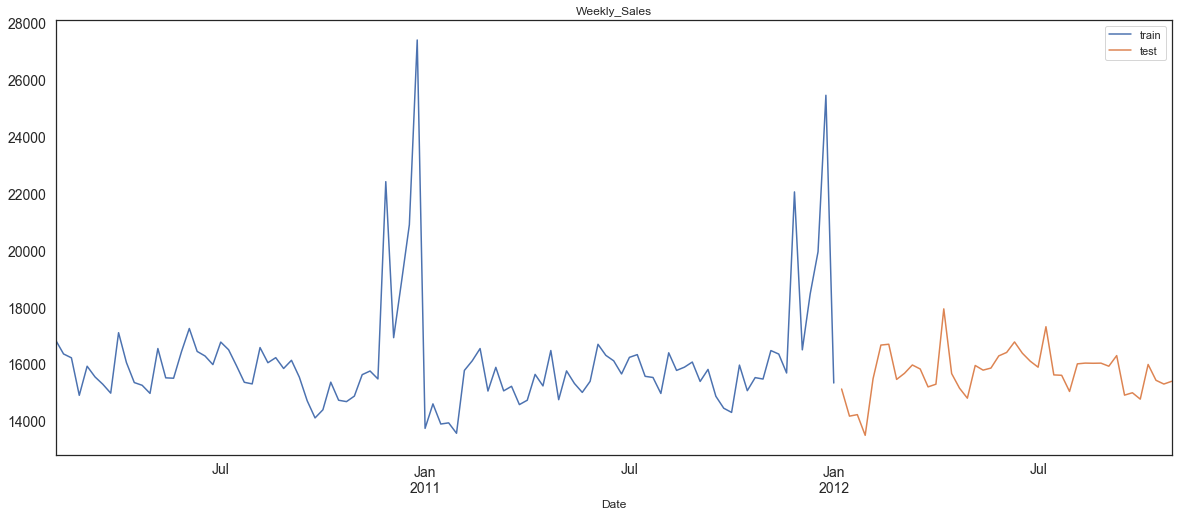

In [134]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

In [135]:
model_auto_arima = auto_arima(y_train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(y_train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1812.876, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1807.819, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1806.090, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1806.426, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1784.615, Time=0.17 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1783.615, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.666, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1805.371, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1807.867, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1809.028, Time=0.31 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1786.168, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1803.956, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1805.975, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1804.562, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1802.056, Time=0.53 sec
 ARIMA(3,0

ARIMA(maxiter=200, order=(0, 0, 5), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

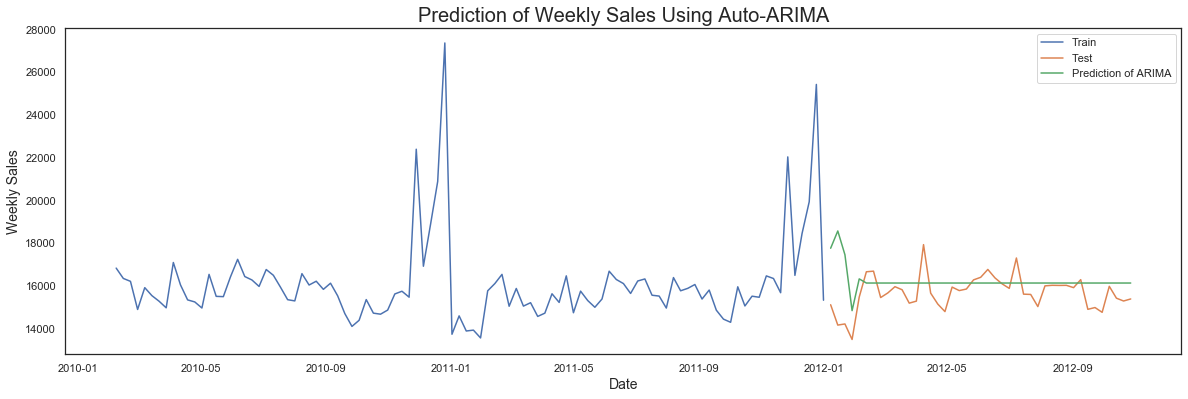

In [136]:
y_pred = model_auto_arima.predict(n_periods=len(y_test))
y_pred1 = pd.DataFrame(y_pred,index = y_test.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred1, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [137]:
def wmae_test(data,test, pred): # WMAE for test
    weights = data['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [138]:
# Performance metric for ARIMA model -MSE/RMSE
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(y_test, y_pred)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(y_test, y_pred))
print('Weighted Mean Absolute Error (WMAE) of ARIMA: ', wmae_test(X_test, y_test, y_pred))

Mean Squared Error (MSE) of ARIMA:  1379701.115961058
Root Mean Squared Error (RMSE) of ARIMA:  1174.606792063224
Mean Absolute Deviation (MAD) of ARIMA:  799.1785182123099
Weighted Mean Absolute Error (WMAE) of ARIMA:  727.4705304716531


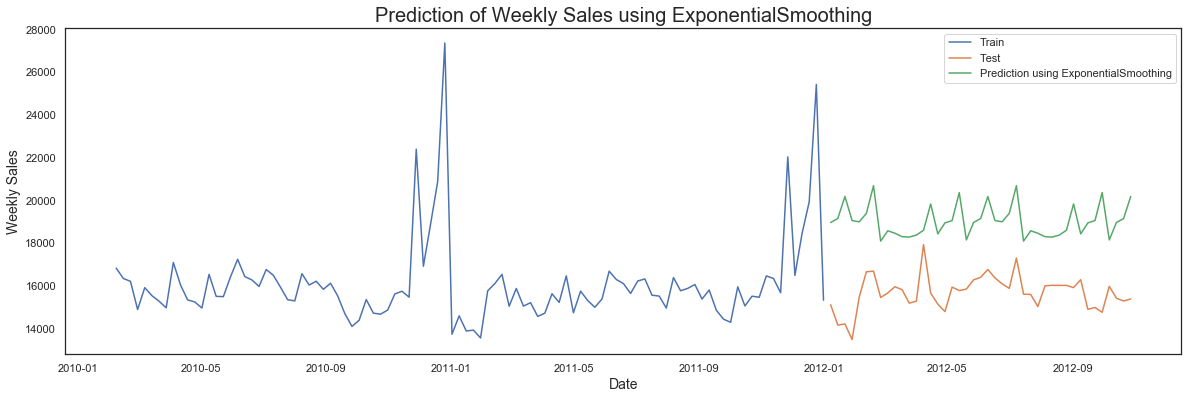

In [139]:
model_holt_winters = ExponentialSmoothing(y_train, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(y_test))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [69]:
# Performance metric for ARIMA model -MSE/RMSE
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(y_test, y_pred)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(y_test, y_pred))
print('Weighted Mean Absolute Error (WMAE) of ARIMA: ', wmae_test(X_test, y_test, y_pred))

Mean Squared Error (MSE) of ARIMA:  12237105.337491125
Root Mean Squared Error (RMSE) of ARIMA:  3498.157420341618
Mean Absolute Deviation (MAD) of ARIMA:  3338.5540056427735
Weighted Mean Absolute Error (WMAE) of ARIMA:  3197.5487192634896


# Autoencoder 

In [61]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import tensorflow as tf 

In [62]:
train_auto = df_train_feats.copy()
test_auto = df_test_feats.copy()

In [63]:
#https://machinelearningmastery.com/autoencoder-for-regression/#:~:text=Autoencoder%20is%20a%20type%20of,and%20a%20decoder%20sub%2Dmodels.
y = train_auto['Weekly_Sales']
X = train_auto.drop(['Weekly_Sales'], axis=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [66]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(295099, 9) (295099,)
(126471, 9) (126471,)


In [84]:
# define encoder
n_inputs = X_train.shape[1]
visible = Input(shape=(n_inputs,))
e = Dense(8, activation='relu')(visible)
e = Dense(6, activation='relu')(e)
e = Dense(4, activation='relu')(e)
e = Dense(2, activation='relu')(e)
# e = BatchNormalization()(e)
#e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [85]:
# define decoder
d = Dense(4, activation='relu')(bottleneck)
d = Dense(6, activation='relu')(d)
d = Dense(8, activation='relu')(d)
d = Dense(9, activation='relu')(d)
# d = BatchNormalization()(d)
#d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [72]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 80        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 27        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

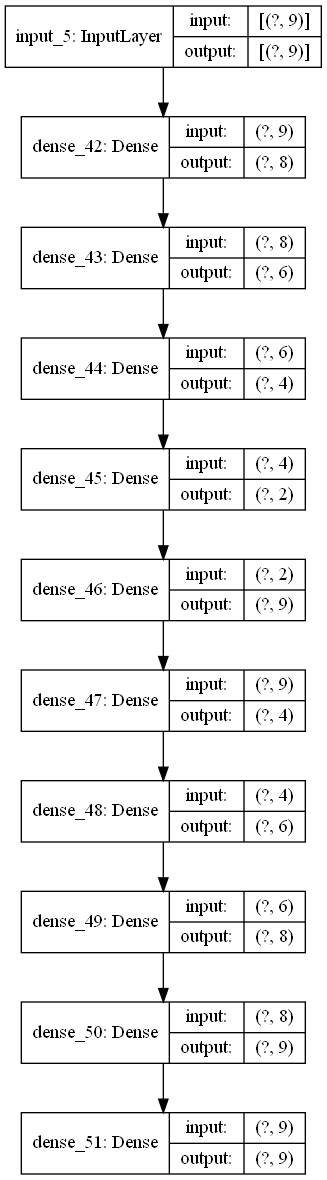

In [86]:
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)

In [74]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=5, batch_size=32, verbose=1, validation_data=(X_test,X_test))

Epoch 1/5
9222/9222 [==============================] - 28s 3ms/step - loss: 0.0657 - val_loss: 0.0532
Epoch 2/5
9222/9222 [==============================] - 31s 3ms/step - loss: 0.0514 - val_loss: 0.0500
Epoch 3/5
9222/9222 [==============================] - 32s 3ms/step - loss: 0.0495 - val_loss: 0.0489
Epoch 4/5
9222/9222 [==============================] - 35s 4ms/step - loss: 0.0489 - val_loss: 0.0486
Epoch 5/5
9222/9222 [==============================] - 26s 3ms/step - loss: 0.0486 - val_loss: 0.0484


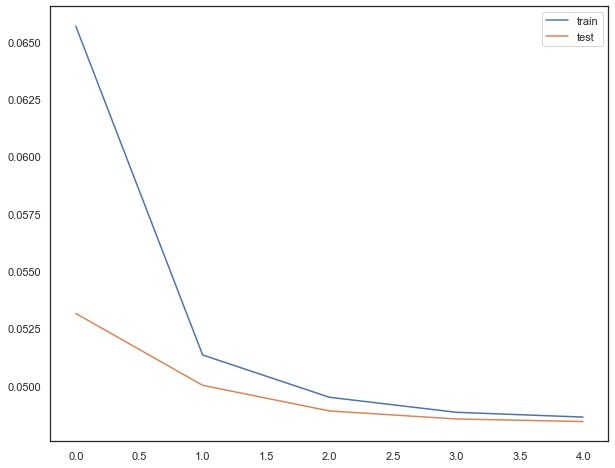

In [87]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

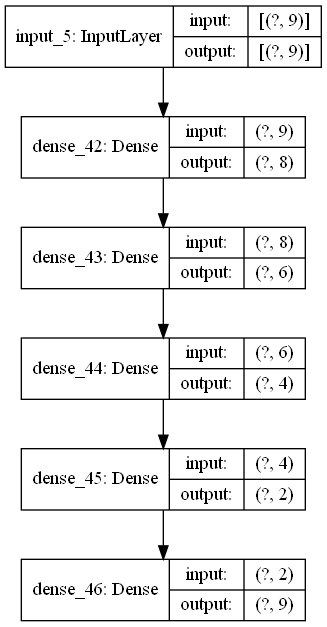

In [88]:

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)

In [89]:
# save the encoder to file
encoder.save('encoder.h5')

# Modeling

In [61]:
y = df_train_feats['Weekly_Sales']
X = df_train_feats.drop(['Weekly_Sales'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.

In [62]:
# Final shapes.
print('Train:', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train: (295099, 9) (295099,)
Test (126471, 9) (126471,)


In [63]:
def wmae(data,test, pred): # WMAE for test
    weights = data['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [64]:
encoder = load_model('encoder.h5')

In [65]:
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

### Linear Regression

In [66]:
# model without auto encoder
model_lr = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train) # Fit the model.
y_pred_train_lr = model_lr.predict(X_train) # Predict train data.
y_pred_test_lr = model_lr.predict(X_test) # Predict test data.

In [67]:
print("Train WMAE-", wmae(X_train, y_train, y_pred_train_lr))
print("Test WMAE-", wmae(X_test, y_test, y_pred_test_lr))
print("Train RMSE:", mean_squared_error(y_train, y_pred_train_lr, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test_lr, squared=False))

Train WMAE- 14778.865150857444
Test WMAE- 14822.671651296834
Train RMSE: 21725.585423047418
Test RMSE: 21698.894470455565


In [120]:
#model with auto encoder
model_lr1 = LinearRegression(fit_intercept=True,normalize=True).fit(X_train_encode,y_train)
y_pred_train_lr = model_lr1.predict(X_train_encode) # Predict train data.
#y_pred_cv_lr = model_lr1.predict(X_cv_encode) # Predict cv data.
y_pred_test_lr = model_lr1.predict(X_test_encode) # Predict test data.

In [121]:
y_pred_test_lr

array([22353.375, 12845.376,  7175.126, ..., 14148.376, 15132.376,
        6943.626], dtype=float32)

In [122]:
print("Train WMAE-", wmae(X_train, y_train, y_pred_train_lr))
#print("CV WMAE-", wmae(X_cv, y_cv, y_pred_cv_lr))
print("Test WMAE-", wmae(X_test, y_test, y_pred_test_lr))
print("Train RMSE:", mean_squared_error(y_train, y_pred_train_lr, squared=False))
#print("CV RMSE:", mean_squared_error(y_cv, y_pred_cv_lr, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test_lr, squared=False))

Train WMAE- 14657.584229184095
Test WMAE- 14791.064589114672
Train RMSE: 21936.0379427365
Test RMSE: 22235.009341295972


- As we can observe that wmae is decreased when we used auto encoders.

### KNN

In [68]:
#model without auto encoder
neigh = KNeighborsRegressor(n_jobs=-1)
parameters = {'n_neighbors':list(range(1,26,3))}
clf = RandomizedSearchCV(neigh, parameters, cv=4)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=KNeighborsRegressor(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 4, 7, 10, 13, 16, 19,
                                                        22, 25]})

In [69]:
clf.best_estimator_

KNeighborsRegressor(n_jobs=-1, n_neighbors=16)

In [74]:
neigh = KNeighborsRegressor(n_neighbors=16, n_jobs=-1)
neigh.fit(X_train, y_train)
y_tr_knn = neigh.predict(X_train)
y_test_knn = neigh.predict(X_test)

In [75]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_knn))
print("Test WMAE-", wmae(X_test, y_test, y_test_knn))
print("Train RMSE:", mean_squared_error(y_train, y_tr_knn, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_knn, squared=False))

Train WMAE- 9695.595286717362
Test WMAE- 10337.438981179934
Train RMSE: 15163.77748240932
Test RMSE: 16014.792652792197


In [138]:
#model with auto encoder
neigh = KNeighborsRegressor(n_jobs=-1)
parameters = {'n_neighbors':list(range(1,26,3))}
clf = RandomizedSearchCV(neigh, parameters, cv=4)
clf.fit(X_train_encode, y_train)

RandomizedSearchCV(cv=4, estimator=KNeighborsRegressor(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 4, 7, 10, 13, 16, 19,
                                                        22, 25]})

In [141]:
clf.best_estimator_

KNeighborsRegressor(n_jobs=-1, n_neighbors=16)

In [143]:
neigh = KNeighborsRegressor(n_neighbors=16, n_jobs=-1)
neigh.fit(X_train_encode, y_train)
y_tr_knn = neigh.predict(X_train_encode)
#y_cv_knn = neigh.predict(X_cv_encode)
y_test_knn = neigh.predict(X_test_encode)

In [145]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_knn))
#print("CV WMAE-", wmae(X_cv, y_cv, y_cv_knn))
print("Test WMAE-", wmae(X_test, y_test, y_test_knn))
print("Train RMSE:", mean_squared_error(y_train, y_tr_knn, squared=False))
#print("CV RMSE:", mean_squared_error(y_cv, y_cv_knn, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_knn, squared=False))

Train WMAE- 11075.19755239729
Test WMAE- 11954.023716691026
Train RMSE: 17242.34132164854
Test RMSE: 18742.376735518697


### Decision Tree

In [76]:
#model without auto encoder
dt = DecisionTreeRegressor()
parametres = {'max_depth': [1,5,10,15,20,25,30,35], 'min_samples_leaf': [1,2,3,4,5,6,7,8]}
clf = RandomizedSearchCV(dt, parametres, cv=4)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 5, 10, 15, 20, 25, 30,
                                                      35],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8]})

In [77]:
clf.best_estimator_

DecisionTreeRegressor(max_depth=30, min_samples_leaf=3)

In [78]:
dt = DecisionTreeRegressor(max_depth=30,min_samples_leaf=3)
dt.fit(X_train, y_train)
y_tr_dt = dt.predict(X_train)
y_test_dt = dt.predict(X_test)

In [79]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_dt))
print("Test WMAE-", wmae(X_test, y_test, y_test_dt))
print("Train RMSE:", mean_squared_error(y_train, y_tr_dt, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_dt, squared=False))

Train WMAE- 951.3778096363985
Test WMAE- 1765.629407261115
Train RMSE: 2271.883500587858
Test RMSE: 4042.185189345318


In [121]:
# model with auto encoder
dt = DecisionTreeRegressor()
parametres = {'max_depth': [1,5,10,15,20,25,30,35], 'min_samples_leaf': [1,2,3,4,5,6,7,8]}
clf = RandomizedSearchCV(dt, parametres, cv=3)
clf.fit(X_train_encode, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 5, 10, 15, 20, 25, 30,
                                                      35],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8]})

In [122]:
clf.best_estimator_

DecisionTreeRegressor(max_depth=20, min_samples_leaf=7)

In [108]:
dt = DecisionTreeRegressor(max_depth=20,min_samples_leaf=7)
dt.fit(X_train_encode, y_train)
y_tr_dt = dt.predict(X_train_encode)
y_test_dt = dt.predict(X_test_encode)

In [109]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_dt))
print("Test WMAE-", wmae(X_test, y_test, y_test_dt))
print("Train RMSE:", mean_squared_error(y_train, y_tr_dt, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_dt, squared=False))

Train WMAE- 9456.563224349877
Test WMAE- 11424.082275622828
Train RMSE: 15510.48083668539
Test RMSE: 18369.92054535224


### Random Forest

In [80]:
# model without auto encoder
rf = RandomForestRegressor()
parametres = {'max_depth':[1,5,10,15,20,25,30,35,40,45,50],\
              'n_estimators':[10,20,30,40,50,60,70,80,90,100,110]}
clf = RandomizedSearchCV(rf, parametres, cv=4)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [1, 5, 10, 15, 20, 25, 30,
                                                      35, 40, 45, 50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100,
                                                         110]})

In [81]:
clf.best_estimator_

RandomForestRegressor(max_depth=40, n_estimators=90)

In [82]:
rf = RandomForestRegressor(max_depth=40,
                      n_estimators=90)
rf.fit(X_train, y_train)
y_tr_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

In [83]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_rf))
print("Test WMAE-", wmae(X_test, y_test, y_test_rf))
print("Train RMSE:", mean_squared_error(y_train, y_tr_rf, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_rf, squared=False))

Train WMAE- 540.0693648013472
Test WMAE- 1430.2473753196039
Train RMSE: 1239.5723085767436
Test RMSE: 3285.0776530340595


In [105]:
# model with auto encoder
rf1 = RandomForestRegressor()
parametres = {'max_depth':[1,5,10,15,20,25,30,35,40,45,50], 'n_estimators':[10,20,30,40,50,60,70,80,90,100,110]}
clf = RandomizedSearchCV(rf1, parametres, cv=4)
clf.fit(X_train_encode, y_train)

In [264]:
clf.best_estimator_

RandomForestRegressor(max_depth=35, n_estimators=10)

In [155]:
rf1 = RandomForestRegressor(max_depth=35, n_estimators=10)
rf1.fit(X_train_encode, y_train)
y_tr_rf = rf1.predict(X_train_encode)
y_test_rf = rf1.predict(X_test_encode)

In [156]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_rf))
print("Test WMAE-", wmae(X_test, y_test, y_test_rf))
print("Train RMSE:", mean_squared_error(y_train, y_tr_rf, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_rf, squared=False))

Train WMAE- 4428.097678806323
Test WMAE- 11228.62458260539
Train RMSE: 7734.742735740936
Test RMSE: 18374.06299212689


### xgBoost

In [85]:
xg1 = XGBRegressor()
parametres = {'max_depth':[1,5,10,15,20,25,30,35,40,45,50], 'n_estimators':[10,20,30,40,50,60,70,80,90,100,110]}
clf = RandomizedSearchCV(xg1, parametres, cv=4, n_jobs=-1)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [86]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
xg1 = XGBRegressor(max_depth=10, n_estimators=100)
xg1.fit(X_train, y_train)
y_tr_xg = xg1.predict(X_train)
y_test_xg = xg1.predict(X_test)

In [89]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_xg))
print("Test WMAE-", wmae(X_test, y_test, y_test_xg))
print("Train RMSE:", mean_squared_error(y_train, y_tr_xg, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_xg, squared=False))

Train WMAE- 1171.9891426127367
Test WMAE- 1560.4580906933538
Train RMSE: 1982.7222700871666
Test RMSE: 2975.131001502642


In [139]:
xg = XGBRegressor()
parametres = {'max_depth':[1,5,10,15,20,25,30,35,40,45,50], 'n_estimators':[10,20,30,40,50,60,70,80,90,100,110]}
clf = RandomizedSearchCV(xg, parametres, cv=4)
clf.fit(X_train_encode, y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [140]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=110, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
xg = XGBRegressor(max_depth=20, n_estimators=110)
xg.fit(X_train_encode, y_train)
y_tr_xg = xg.predict(X_train_encode)
y_test_xg = xg.predict(X_test_encode)

In [107]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_xg))
print("Test WMAE-", wmae(X_test, y_test, y_test_xg))
print("Train RMSE:", mean_squared_error(y_train, y_tr_xg, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_xg, squared=False))

Train WMAE- 4674.854512731787
Test WMAE- 11078.149221596406
Train RMSE: 7462.057817206712
Test RMSE: 18330.307016209135


### Adaboost

In [90]:
adaboost = AdaBoostRegressor()
parametres = {'n_estimators': [50, 100],
             'learning_rate' : [0.01,0.05,0.1,0.3,1],
             'loss' : ['linear', 'square', 'exponential']}
clf = RandomizedSearchCV(adaboost, parametres, cv=4,n_iter = 10, n_jobs=-1)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=AdaBoostRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100]})

In [91]:
clf.best_estimator_

AdaBoostRegressor(learning_rate=0.01, loss='exponential')

In [94]:
adaboost = AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=50)
adaboost.fit(X_train, y_train)
y_tr_ad = adaboost.predict(X_train)
y_test_xg = adaboost.predict(X_test)

In [95]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_ad))
print("Test WMAE-", wmae(X_test, y_test, y_test_xg))
print("Train RMSE:", mean_squared_error(y_train, y_tr_ad, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_xg, squared=False))

Train WMAE- 11701.059696280505
Test WMAE- 11709.7452132599
Train RMSE: 17963.860058990842
Test RMSE: 17817.95089778371


In [97]:
#using auto encoder
adaboost1 = AdaBoostRegressor()
parametres = {'n_estimators': [50, 100],
             'learning_rate' : [0.01,0.05,0.1,0.3,1],
             'loss' : ['linear', 'square', 'exponential']}
clf = RandomizedSearchCV(adaboost1, parametres, cv=4,n_iter = 10, n_jobs=-1)
clf.fit(X_train_encode, y_train)

RandomizedSearchCV(cv=4, estimator=AdaBoostRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100]})

In [98]:
clf.best_estimator_

AdaBoostRegressor(learning_rate=0.01, loss='exponential')

In [103]:
adaboost1 = AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=50)
adaboost1.fit(X_train_encode, y_train)
y_tr_ad = adaboost1.predict(X_train_encode)
y_test_ad = adaboost1.predict(X_test_encode)

In [104]:
print("Train WMAE-", wmae(X_train, y_train, y_tr_ad))
print("Test WMAE-", wmae(X_test, y_test, y_test_ad))
print("Train RMSE:", mean_squared_error(y_train, y_tr_ad, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_ad, squared=False))

Train WMAE- 14680.670980631923
Test WMAE- 14734.37899757346
Train RMSE: 21897.72374348944
Test RMSE: 21897.10013706622


In [3]:
pretty_table = PrettyTable()
pretty_table.field_names = ['Model', 'WMAE', 'RMSE']
pretty_table.add_row(['Linear Regression(without auto_encoder)', 14778.86, 21698.894])
pretty_table.add_row(['Linear Regression(with auto_encoder)', 14791.064, 22235.009])
pretty_table.add_row(['\n', '\n', '\n'])
pretty_table.add_row(['KNN(without auto_encoder)', 10337.438, 16014.792])
pretty_table.add_row(['KNN(with auto_encoder)', 11954.02, 18742.376])
pretty_table.add_row(['\n', '\n', '\n'])
pretty_table.add_row(['Decision Tree(without auto_encoder)', 1765.629, 4042.185])
pretty_table.add_row(['Decision Tree(with auto_encoder)', 11424.082, 18369.920])
pretty_table.add_row(['\n', '\n', '\n'])
pretty_table.add_row(['Random Forest(without auto_encoder)', 1430.247, 3285.07])
pretty_table.add_row(['Random Forest(with auto_encoder)', 11228.624, 18374.062])
pretty_table.add_row(['\n', '\n', '\n'])
pretty_table.add_row(['XGBRegressor(without auto_encoder)', 1560.45, 2975.13])
pretty_table.add_row(['XGBRegressor(with auto_encoder)', 11078.14, 18330.30])
pretty_table.add_row(['\n', '\n', '\n'])
pretty_table.add_row(['Adaboost(without auto_encoder)', 11709.745, 17817.950])
pretty_table.add_row(['Adaboost(with auto_encoder)', 14734.37, 21897.100])
print(pretty_table)

+-----------------------------------------+-----------+-----------+
|                  Model                  |    WMAE   |    RMSE   |
+-----------------------------------------+-----------+-----------+
| Linear Regression(without auto_encoder) |  14778.86 | 21698.894 |
|   Linear Regression(with auto_encoder)  | 14791.064 | 22235.009 |
|                                         |           |           |
|                                         |           |           |
|        KNN(without auto_encoder)        | 10337.438 | 16014.792 |
|          KNN(with auto_encoder)         |  11954.02 | 18742.376 |
|                                         |           |           |
|                                         |           |           |
|   Decision Tree(without auto_encoder)   |  1765.629 |  4042.185 |
|     Decision Tree(with auto_encoder)    | 11424.082 |  18369.92 |
|                                         |           |           |
|                                         |     

In [134]:
date = test['Date']
test_relevant = test.drop(['Date','Temperature','Fuel_Price','CPI', 'Unemployment'], axis=1)
test_relevant

,Store,IsHoliday,Type,Size,Dept,Month,Week,Year,day
0,1,0,3,151315,1,11,44,2012,2
1,1,0,3,151315,2,11,44,2012,2
2,1,0,3,151315,3,11,44,2012,2
3,1,0,3,151315,4,11,44,2012,2
4,1,0,3,151315,5,11,44,2012,2
...,...,...,...,...,...,...,...,...,...
115059,45,0,2,118221,93,7,30,2013,26
115060,45,0,2,118221,94,7,30,2013,26
115061,45,0,2,118221,95,7,30,2013,26
115062,45,0,2,118221,97,7,30,2013,26


In [135]:
test_relevant = test_relevant.sort_values(['Store', 'Dept'], ascending=[True, True])
test_relevant

,Store,IsHoliday,Type,Size,Dept,Month,Week,Year,day
0,1,0,3,151315,1,11,44,2012,2
71,1,0,3,151315,1,11,45,2012,9
142,1,0,3,151315,1,11,46,2012,16
213,1,3,3,151315,1,11,47,2012,23
285,1,0,3,151315,1,11,48,2012,30
...,...,...,...,...,...,...,...,...,...
114798,45,0,2,118221,98,6,26,2013,28
114863,45,0,2,118221,98,7,27,2013,5
114930,45,0,2,118221,98,7,28,2013,12
114997,45,0,2,118221,98,7,29,2013,19


In [136]:
y_pred_rf = rf.predict(test_relevant)

In [137]:
y_pred_rf

array([38642.76066667, 20050.53244444, 19512.54866667, ...,
         762.42466667,   791.82322222,   631.057     ])

In [138]:
test_relevant['Date'] = date
test_relevant = test_relevant.sort_values(['Store', 'Dept'], ascending=[True, True])
test_relevant['Weekly_Sales'] = y_pred_rf
test_relevant

,Store,IsHoliday,Type,Size,Dept,Month,Week,Year,day,Date,Weekly_Sales
0,1,0,3,151315,1,11,44,2012,2,2012-11-02,38642.760667
71,1,0,3,151315,1,11,45,2012,9,2012-11-09,20050.532444
142,1,0,3,151315,1,11,46,2012,16,2012-11-16,19512.548667
213,1,3,3,151315,1,11,47,2012,23,2012-11-23,19921.575778
285,1,0,3,151315,1,11,48,2012,30,2012-11-30,23087.515889
...,...,...,...,...,...,...,...,...,...,...,...
114798,45,0,2,118221,98,6,26,2013,28,2013-06-28,663.290667
114863,45,0,2,118221,98,7,27,2013,5,2013-07-05,713.823667
114930,45,0,2,118221,98,7,28,2013,12,2013-07-12,762.424667
114997,45,0,2,118221,98,7,29,2013,19,2013-07-19,791.823222


In [139]:
sampleSubmission = pd.read_csv('sampleSubmission.csv', sep=',')

In [140]:
sampleSubmission['Weekly_Sales'] = y_pred_rf
sampleSubmission.to_csv('submission.csv',index=False)
sampleSubmission

,Id,Weekly_Sales
0,1_1_2012-11-02,38642.760667
1,1_1_2012-11-09,20050.532444
2,1_1_2012-11-16,19512.548667
3,1_1_2012-11-23,19921.575778
4,1_1_2012-11-30,23087.515889
...,...,...
115059,45_98_2013-06-28,663.290667
115060,45_98_2013-07-05,713.823667
115061,45_98_2013-07-12,762.424667
115062,45_98_2013-07-19,791.823222
